# Exercise Session 7: Influence of Basis Functions

The goal of this exercise is to illustrate the influence of the choice of basis functions on the learned model. We will learn multiple models for a synthetic dataset that describes friction data. The model is taken from "Stick-Slip Friction Modeling in Tube Expansion", from Pervez et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6) # Default figsize

In [2]:
np.random.seed(42)

We start by creating the data generator:

In [3]:
def friction_model(v, F_coulomb, F_s, stribeck_coef, viscous_coef, noise_std=None):
    F_b = F_coulomb + F_s
    v_coulomb = F_s / stribeck_coef
    
    strib = np.abs(v) < v_coulomb
    notstrib = np.logical_not(strib)
    
    force = np.zeros_like(v)
    force[strib] = np.sign(v[strib]) * (F_b - stribeck_coef * np.abs(v)[strib])
    force[notstrib] = np.sign(v[notstrib]) * F_coulomb + (v[notstrib] - np.sign(v[notstrib]) * v_coulomb) * viscous_coef
    
    if noise_std is not None:
        force += noise_std * np.random.normal(size=v.shape)
    
    return force

def create_dataset(N, v=None):
    # Values read from Fig. 1.a. of the cited article
    F_coulomb = 1.25
    F_s = .75
    stribeck_coef = 5
    viscous_coef = 1
    
    noise_std = 0.2
    
    if v is None:
        v = np.sort(np.random.uniform(-1, 1, N))
    F = friction_model(v, F_coulomb, F_s, stribeck_coef, viscous_coef, noise_std=noise_std)
    return v, F

We can plot the model:

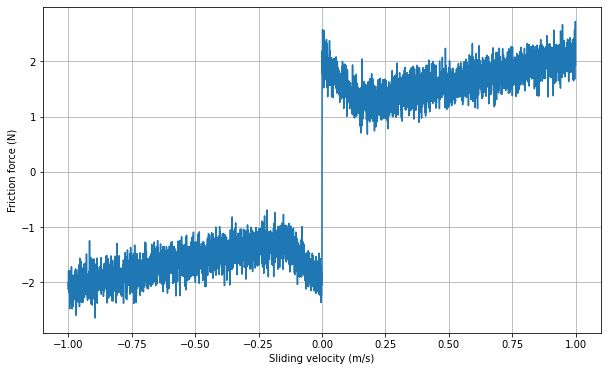

In [4]:
N_plot = 5000
X_plot = np.linspace(-1, 1, N_plot)
_, Y_plot = create_dataset(N_plot, v=X_plot)
# plt.figure(figsize=(10,6))
plt.plot(X_plot, Y_plot)
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)

We are given the following dataset with $N = 1000$ points:

In [5]:
N = 1000
X_raw, Y_raw = create_dataset(N)

print(f'X:\n{X_raw[:5]}\nY:\n{Y_raw[:5]}')

X:
[-0.99951799 -0.99919691 -0.99714331 -0.99268738 -0.99233942]
Y:
[-2.00805313 -1.67955262 -2.12475978 -1.97446015 -2.11373371]


## Data Preparation

We need to split the dataset `X_raw, Y_raw` into three sub parts: training, validation, and testing.
We adopt the split 60-20-20.
**Careful**: we need to make sure that the data is correctly shuffled before splitting!

In [6]:
def split(X, Y, prop):
    N = X.shape[0]
    n_split = int(np.ceil(prop * N))
    x1 = X[:n_split]
    y1 = Y[:n_split]
    x2 = X[n_split:]
    y2 = Y[n_split:]
    return x1, x2, y1, y2

permutation = np.random.permutation(N) 
X = X_raw[permutation]
Y = Y_raw[permutation]

X_train, X_rest, Y_train, Y_rest = split(X, Y, 0.6)
X_val, X_test, Y_val, Y_test = split(X_rest, Y_rest, 0.5)

print(f'Number of:\n\tTraining samples: {X_train.shape[0]}\n\tValidation samples: {X_val.shape[0]}\n'
      f'\tTesting samples: {X_test.shape[0]}')

Number of:
	Training samples: 600
	Validation samples: 200
	Testing samples: 200


## Preliminaries: Implementing linear regression

We start by implementing a `linear_regression` function that takes as input the feature matrix, the data to predict, and returns the weights. We allow for L2-regularization.

In [7]:
def linear_regression(phi, y, reg=0):
    M = phi.shape[1]
    A = phi.T @ phi + reg * np.eye(M)
    b = phi.T @ y
    w = np.linalg.solve(A, b)
    return w

def predict_from_features(phi, w):
    return phi @ w

def compute_error(y_pred, y):
    return np.linalg.norm(y_pred - y) / 2

## Part 1: Polynomial Linear Regression

### Model training

We start by fitting a polynomial linear model to this data.
We implement a function that returns the polynomial feature matrix given the degree M.

In [8]:
def polynomial_feature_matrix(x, M):
    return np.vstack([x**k for k in range(M+1)]).T

def predict_with_polynomial_features(x, w):
    M = w.shape[0] - 1
    phi = polynomial_feature_matrix(x, M)
    return predict_from_features(phi, w)

We can now fit a polynomial curve to the training data for various degrees:

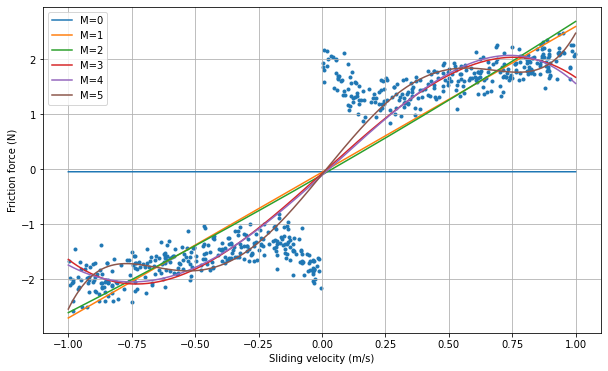

In [9]:
Ms = np.arange(6)
w_poly = []
for M in Ms:
    phi = polynomial_feature_matrix(X_train, M)
    w_poly.append(linear_regression(phi, Y_train, reg=0))

# Plotting
plt.scatter(X_train, Y_train, marker='.')
for k in range(Ms.shape[0]):
    plt.plot(X_plot, predict_with_polynomial_features(X_plot, w_poly[k]), label=f'M={Ms[k]}')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)

We observe a very specific pattern: the fitted polynomials of order $2k+1$ seem to be equal to the fitted polynomials of order $2(k+1)$.
Polynomials of degree even seem to not be useful in the prediction!
We verify that by plotting the weights of each degree:

(-0.5, 6.5)

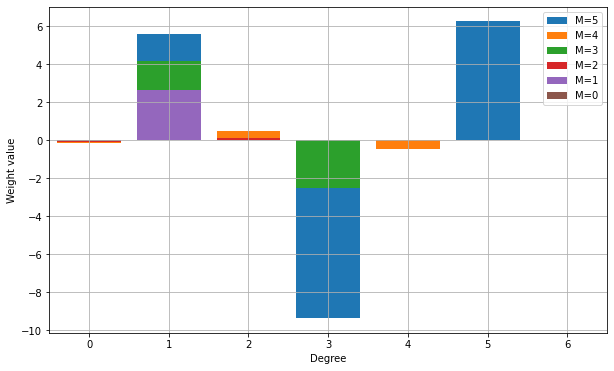

In [10]:
for k in range(len(w_poly)-1, -1, -1):
    plt.bar(np.arange(len(w_poly[k])),w_poly[k], label=f'M={Ms[k]}')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Weight value')
plt.grid()
plt.xlim(-0.5, len(w_poly) + 0.5)

Indeed, the weights of even powers of the input are (approximately) $0$. This indicates that we can drop the even powers in our approximation:

In [11]:
def odd_polynomial_feature_matrix(x, M):
    return np.vstack([x**k for k in range(1, M+1, 2)]).T

def predict_with_odd_polynomial_features(x, w):
    M = w.shape[0]*2 - 1
    phi = odd_polynomial_feature_matrix(x, M)
    return predict_from_features(phi, w)

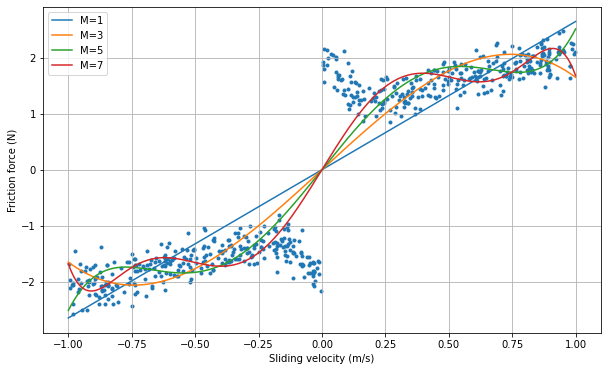

In [12]:
Ms = np.arange(1, 8, 2)
w_poly = []
for M in Ms:
    phi = odd_polynomial_feature_matrix(X_train, M)
    w_poly.append(linear_regression(phi, Y_train, reg=0))

# Plotting
plt.scatter(X_train, Y_train, marker='.')
for k in range(Ms.shape[0]):
    plt.plot(X_plot, predict_with_odd_polynomial_features(X_plot, w_poly[k]), label=f'M={Ms[k]}')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)

### Model selection

The time has now come to select the "best" polynomial. Ideally, we would like to select the one that performs the best on unseen data. Therefore, we perform **model selection** on the validation data.

We start by training a large number of models with different values for the hyperparameter $M$:

In [13]:
Ms = np.arange(1, 30, 2)
w_poly = []
for M in Ms:
    phi = odd_polynomial_feature_matrix(X_train, M)
    w_poly.append(linear_regression(phi, Y_train, reg=0))

Then, we perform prediction on the validation data, and plot the prediction error as a function of the hyperparameter $M$:

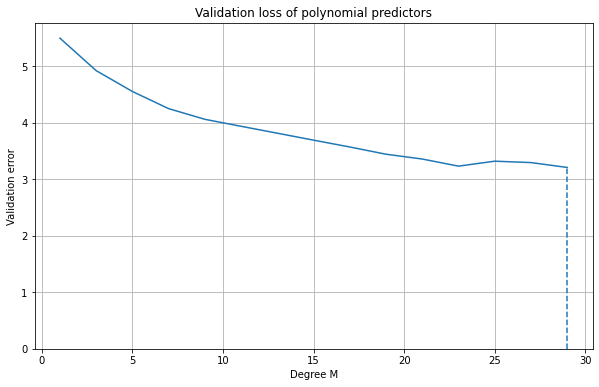

In [14]:
predictions = [predict_with_odd_polynomial_features(X_val, w) for w in w_poly]
errors = [compute_error(y_pred, Y_val) for y_pred in predictions]
errors = np.array(errors)

arg_M_star = np.argmin(errors)
M_star = Ms[arg_M_star]

plt.plot(Ms, errors)
plt.vlines(M_star, ymin=0, ymax=errors[arg_M_star], linestyle='dashed')
plt.xlabel('Degree M')
plt.ylabel('Validation error')
plt.grid()
plt.title('Validation loss of polynomial predictors')
_=plt.ylim(0)

Here, it seems that the best degree is $M = 29$. We can visualize the model:

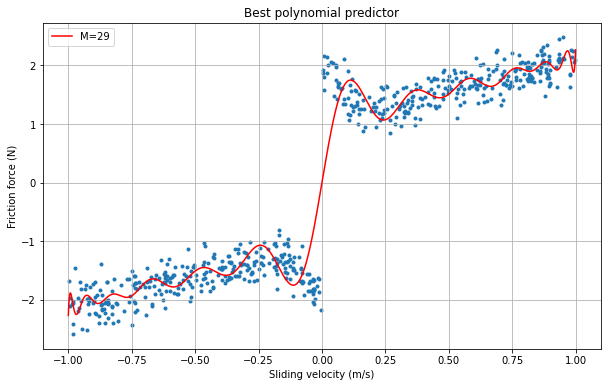

In [15]:
w_poly_star = w_poly[arg_M_star]

plt.scatter(X_train, Y_train, marker='.')
plt.plot(X_plot, predict_with_odd_polynomial_features(X_plot, w_poly_star), label=f'M={M_star}', color='r')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)
_=plt.title('Best polynomial predictor')

Notice the sharp variation of the predicted curve on the boundary of the interval (near $\pm 1$). This is a clear sign of high variance and high values of the weights. We can confirm that by plotting the norm of $w$ for increasing values of $M$:

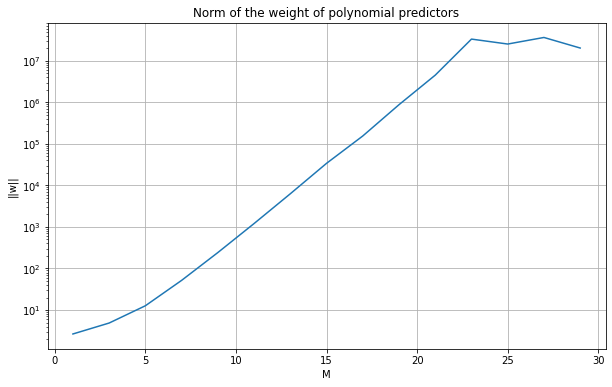

In [16]:
norms = [np.linalg.norm(w) for w in w_poly]
plt.semilogy(Ms, norms)
plt.grid()
plt.title('Norm of the weight of polynomial predictors')
plt.ylabel('||w||')
_=plt.xlabel('M')

Notice the logarithmic y-axis: the norm increases exponentially with $M$.

The polynomial model therefore seems to lead to correct predictions, but has very high variance. This class of basis function is not adapted to represent the true data. Can we find a better hypothesis class?

## Part 2: Modelling a discontinuity

The data clearly shows a discontinuity of the true function at $v = 0$. Polynomials are continuous and are a terrible model for discontinuous functions. We can model this feature by incorporating the following function in our basis functions:
$$h:v \mapsto \begin{cases}1,&\text{if}~v \geq 0,\\ -1,&\text{otherwise}.\end{cases}$$

We can re-do the previous pipeline with this function:

In [17]:
def discontinuous_polynomial_feature_matrix(x, M):
    discontinuity = np.sign(x)
    poly = np.vstack([x**k for k in range(1, M+1, 2)])
    return np.vstack((discontinuity, poly)).T

def predict_with_discontinuous_polynomial_features(x, w):
    M = (w.shape[0]-1)*2 - 1
    phi = discontinuous_polynomial_feature_matrix(x, M)
    return predict_from_features(phi, w)

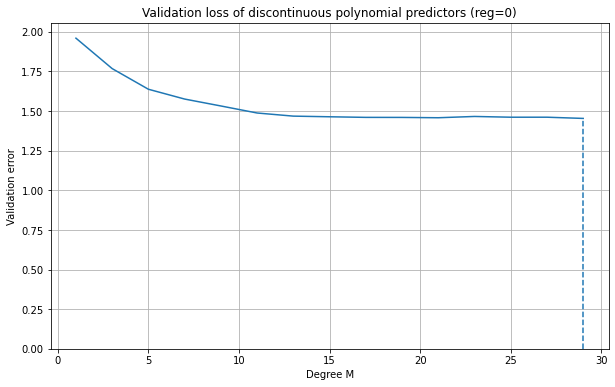

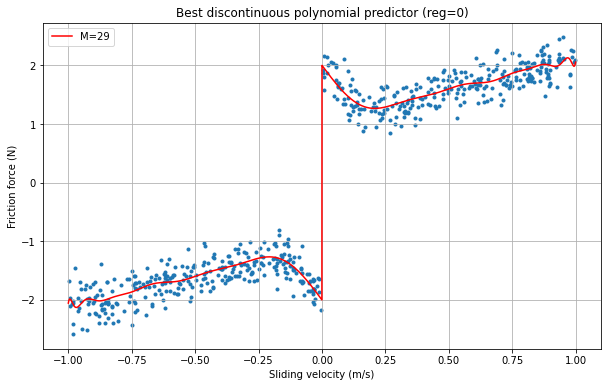

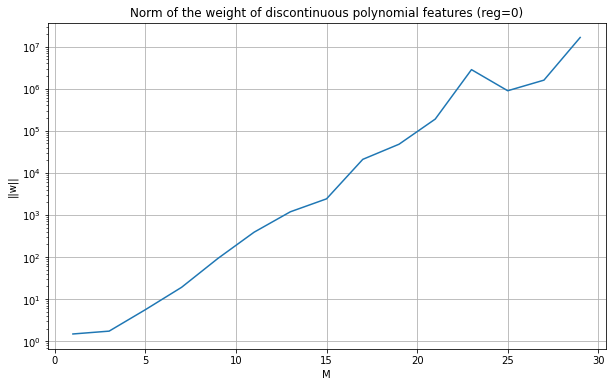

In [18]:
def find_best_discontinuous_predictor(reg=0):
    # Model training
    Ms = np.arange(1, 30, 2)
    w_disc = []
    for M in Ms:
        phi = discontinuous_polynomial_feature_matrix(X_train, M)
        w_disc.append(linear_regression(phi, Y_train, reg=reg))

    # Model selection
    predictions = [predict_with_discontinuous_polynomial_features(X_val, w) for w in w_disc]
    errors = [compute_error(y_pred, Y_val) for y_pred in predictions]
    errors = np.array(errors)

    arg_M_disc = np.argmin(errors)
    M_disc = Ms[arg_M_disc]

    plt.plot(Ms, errors)
    plt.vlines(M_disc, ymin=0, ymax=errors[arg_M_disc], linestyle='dashed')
    plt.xlabel('Degree M')
    plt.ylabel('Validation error')
    plt.grid()
    _=plt.ylim(0)
    plt.title(f'Validation loss of discontinuous polynomial predictors (reg={reg})')

    w_disc_star = w_disc[arg_M_disc]

    plt.figure()
    plt.scatter(X_train, Y_train, marker='.')
    plt.plot(X_plot, predict_with_discontinuous_polynomial_features(X_plot, w_disc_star), label=f'M={M_disc}', color='r')
    plt.legend()
    plt.xlabel('Sliding velocity (m/s)')
    plt.ylabel('Friction force (N)')
    plt.grid(True)
    _=plt.title(f'Best discontinuous polynomial predictor (reg={reg})')
    
    plt.figure()
    norms = [np.linalg.norm(w) for w in w_disc]
    plt.semilogy(Ms, norms)
    plt.grid()
    plt.title(f'Norm of the weight of discontinuous polynomial features (reg={reg})')
    plt.ylabel('||w||')
    _=plt.xlabel('M')
    
    return w_disc, arg_M_disc, M_disc

w_disc, arg_M_disc, M_disc = find_best_discontinuous_predictor(reg=0)

We immediately notice three points:
* The validation error is significantly lower for the best discontinuous predictor than for the best polynomial predictor
* The prediction near $v = 0$ looks far more accurate
* The weights are still very large. 

We fight this last point with regularization:


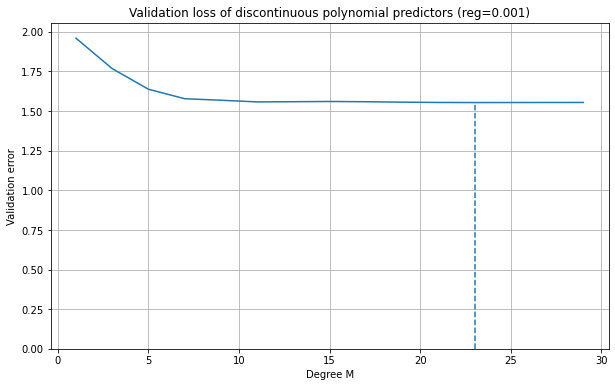

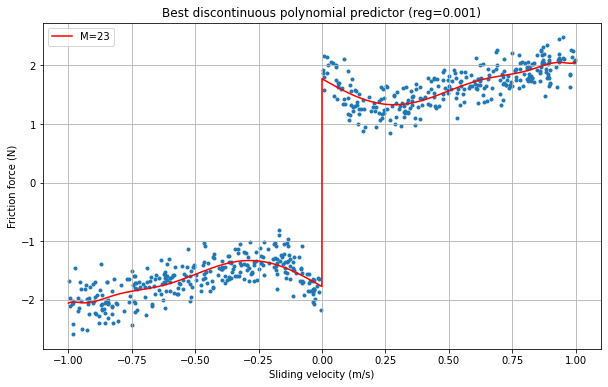

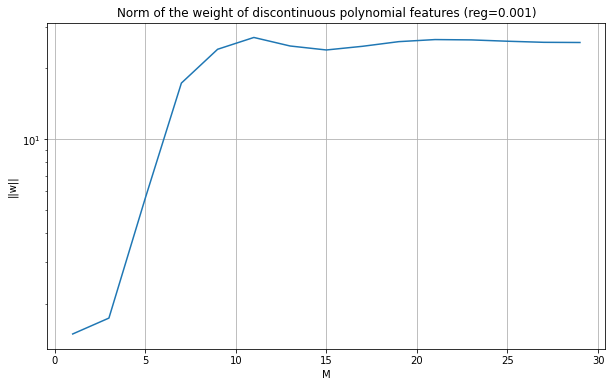

In [19]:
reg = 0.001
w_disc_reg, arg_M_disc_reg, M_disc_reg = find_best_discontinuous_predictor(reg=reg)

We see the dramatic impact of regularization; it decreases the weights by several orders of magnitude while keeping consistent performance.

## Part 3: Modelling a discontinuous derivative

We see that, around $v = \pm 0.25$, the true function seems to change slope abruptly, symmetrically from the origin. We can also incorporate that feature in the basis functions:

$$h_\mathrm{not~diff}:v\mapsto \begin{cases}
    v - 0.25,~\text{if}~v\geq 0.25,\\
    v + 0.25,~\text{if}~v\leq -0.25,\\
    0,~\text{otherwise}.
\end{cases}$$

Let us try that.

In [20]:
def relu(x):
    return np.maximum(0, x)

def nondiff_polynomial_feature_matrix(x, M):
    discontinuity = np.sign(x)
    nondifferentiability = relu(x - 0.25) - relu(-x - 0.25)
    poly = np.vstack([x**k for k in range(1, M+1, 2)])
    return np.vstack((discontinuity, nondifferentiability, poly)).T

def predict_with_nondiff_polynomial_features(x, w):
    M = (w.shape[0]-2)*2 - 1
    phi = nondiff_polynomial_feature_matrix(x, M)
    return predict_from_features(phi, w)

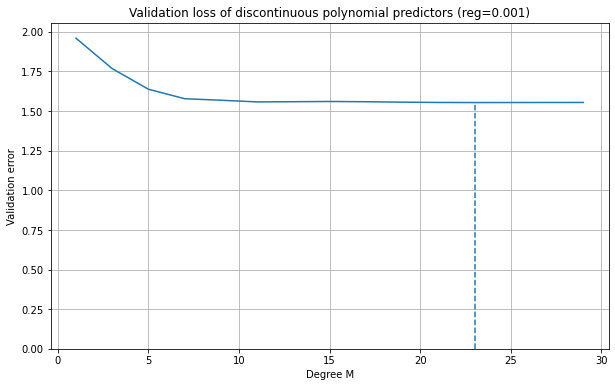

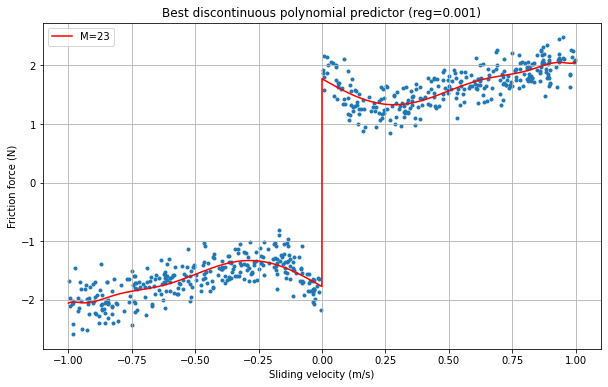

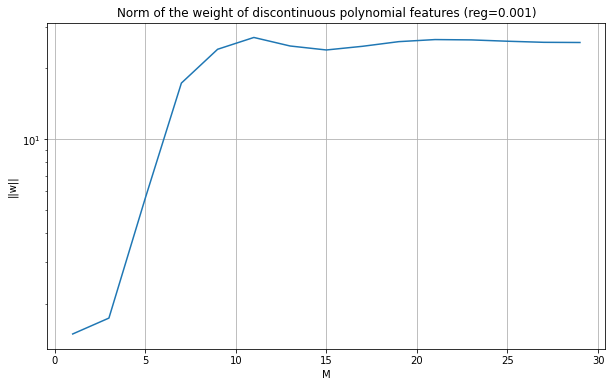

In [21]:
def find_best_nondiff_predictor(reg=0):
    # Model training
    Ms = np.arange(1, 30, 2)
    w_nondiff = []
    for M in Ms:
        phi = nondiff_polynomial_feature_matrix(X_train, M)
        w_disc.append(linear_regression(phi, Y_train, reg=reg))

    # Model selection
    predictions = [predict_with_nondiff_polynomial_features(X_val, w) for w in w_nondiff]
    errors = [compute_error(y_pred, Y_val) for y_pred in predictions]
    errors = np.array(errors)

    arg_M_nondiff = np.argmin(errors)
    M_nondiff = Ms[arg_M_nondiff]

    plt.plot(Ms, errors)
    plt.vlines(M_nondiff, ymin=0, ymax=errors[arg_M_nondiff], linestyle='dashed')
    plt.xlabel('Degree M')
    plt.ylabel('Validation error')
    plt.grid()
    _=plt.ylim(0)
    plt.title(f'Validation loss of nondifferentiable polynomial predictors (reg={reg})')

    w_nondiff_star = w_disc[arg_M_nondiff]

    plt.figure()
    plt.scatter(X_train, Y_train, marker='.')
    plt.plot(X_plot, predict_with_nondiff_polynomial_features(X_plot, w_nondiff_star), label=f'M={M_nondiff}', color='r')
    plt.legend()
    plt.xlabel('Sliding velocity (m/s)')
    plt.ylabel('Friction force (N)')
    plt.grid(True)
    _=plt.title(f'Best nondifferentiable polynomial predictor (reg={reg})')
    
    plt.figure()
    norms = [np.linalg.norm(w) for w in w_nondiff]
    plt.semilogy(Ms, norms)
    plt.grid()
    plt.title(f'Norm of the weight of nondifferentiable polynomial features (reg={reg})')
    plt.ylabel('||w||')
    _=plt.xlabel('M')
    
    return w_nondiff, arg_M_nondiff, M_nondiff

w_nondiff, arg_M_nondiff, M_nondiff = find_best_discontinuous_predictor(reg=0.001)

## Part 4: Choosing the best model

We now want to choose the best model among all of the ones above.
To do that, **we cannot use the test data**; otherwise, our final evaluation of the loss on the test data would not be representative of the true loss.

However, we have already use all our validation data. One solution is to split the test data in half, and use the first half for validation. Note that **this first half cannot be used as test data anymore**. We keep the second half for the test at the end.

In [22]:
X_val_2, X_test_2, Y_val_2, Y_test_2 = split(X_test, Y_test, 0.5)

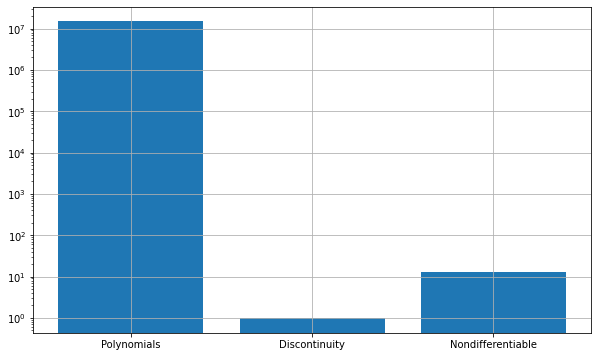

In [23]:
weights = [w_poly_star, w_disc[arg_M_disc], w_nondiff[arg_M_nondiff]]

# Python comment: the list below is a list of functions!
predictors = [
    predict_with_polynomial_features, 
    predict_with_discontinuous_polynomial_features, 
    predict_with_nondiff_polynomial_features
]

errors = []

for w, predictor in zip(weights, predictors):
    y_pred = predictor(X_val_2, w)
    errors.append(compute_error(y_pred, Y_val_2))
    
plt.bar(['Polynomials', 'Discontinuity', 'Nondifferentiable'], errors)
plt.yscale('log')
plt.grid()

best_model = int(np.argmin(errors))
w_best = weights[best_model]
best_predictor = predictors[best_model]

The best model is the discontinuous one.

## Part 5: Evaluation on test data

We are now ready to evaluate on test data.

The average RMS error is 0.1007. We can expect a prediction close to the true function up to this average error on unseen data.


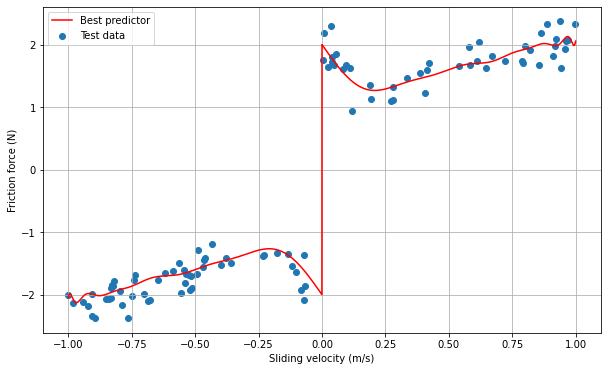

In [24]:
y_pred = best_predictor(X_test_2, w_best)
error = compute_error(y_pred, Y_test_2)
average_rms_error = np.sqrt(error / X_test_2.shape[0])

plt.scatter(X_test_2, Y_test_2, label='Test data')
plt.plot(X_plot, best_predictor(X_plot, w_best), label='Best predictor', color='r')
plt.legend()
plt.grid()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')

print(f'The average RMS error is {average_rms_error:.4f}. We can expect a prediction '
      'close to the true function up to this average error on unseen data.')